In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from GFT_lib import gsp_filter_design as gsp_filt
import numpy as np
import scipy as sp

from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn import manifold, datasets, preprocessing
from sklearn import decomposition

import networkx as nx
import numpy as np
import scipy.spatial as ss

import seaborn as sns
import pandas as pd

import data.datasets as ds
import gsp_lib.util as gsp_util
import gsp_lib.filter as gsp_filter
import gsp_lib.filter_design as gsp_filter_design

from importlib import reload

In [2]:
def plot_pc(df, Y, order=None):
    n_unique = np.unique(Y).size
    if n_unique < 10:
        df['color'] = Y
        if order is None:
            order = list(range(len(df.columns)-1))
    if n_unique < 10:
        pd.tools.plotting.parallel_coordinates(df, 'color', cols=order, colormap=ListedColormap(sns.color_palette("muted")[:n_unique]))
    else:
        gsp_util.parallel_coordinates(df, color='steelblue')
    plt.show()

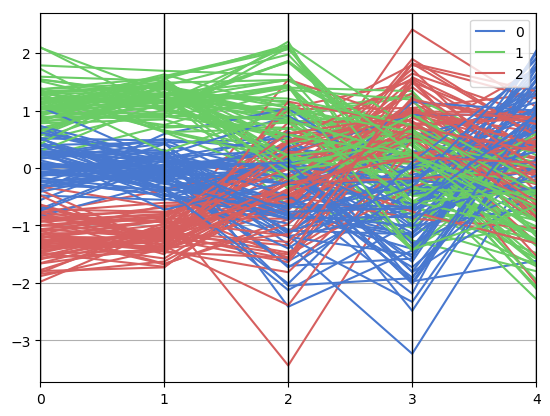

In [3]:
# reload(ds)
X, Y = ds.load_dataset(case=0, n_samples=200, n_features=5, random_state=120, cluster_std=2.3)

prep = True

if prep:
    X = preprocessing.scale(X)
    
n_samples, n_features = X.shape
df = pd.DataFrame(X)
plot_pc(df, Y)

col_names = list(map(str,range(5)))


connected components: 1


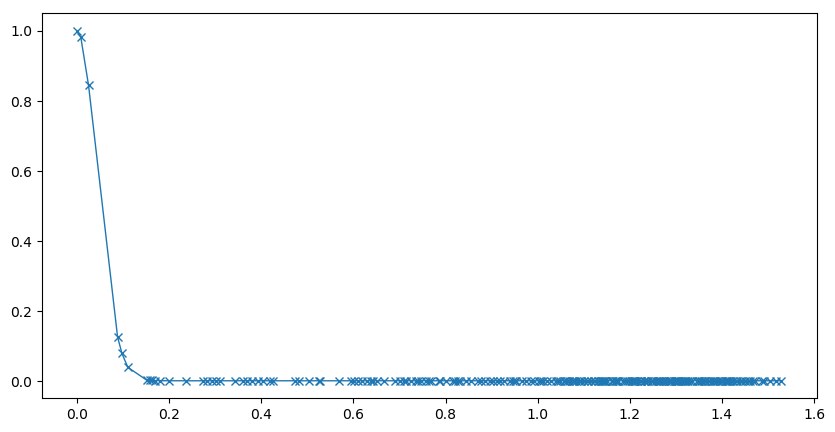

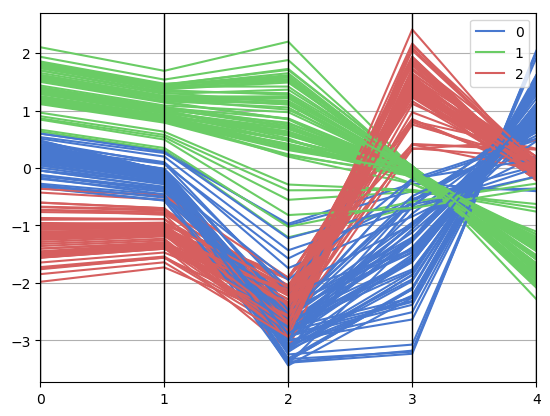

In [4]:
reload(gsp_filter)
n_neighbors = 5

n_comp = None
while n_comp != 1:
    graph = gsp_util.get_graph(X, n_neighbors)
    n_comp = len(list(nx.connected_components(graph['G'])))
    n_neighbors += 1
    
a = .5
b = 1-a

lmax=graph['lam'][-1]
g_l = gsp_filter_design.low_pass_4(lmax, 50)
# g_h = gsp_filter_design.high_pass_4(lmax, 2)

filt =  g_l(graph['lam']) #+ b *g_h(graph['lam'])
graph['filt'] = filt
gsp_util.plot_filter(graph)

pr = gsp_filter.analyze(X, graph)

# imp = gsp_util.compute_importance(X, graph=graph)
# idx = np.argsort(imp)[::-1]
# idx = range(X.shape[1])

data_filtered = pr['data_filtered'].T
dff = pd.DataFrame( data_filtered )

plot_pc(dff,Y)


In [5]:

data = X

threshold = 0.5
neigh = NearestNeighbors(radius=threshold).fit(data)
distances, indices = neigh.radius_neighbors(data)
print(len([a for a in map(len,indices) if a ==1]))

157


In [33]:
from skimage.draw import line_aa, line
from skimage.transform import hough_line
from sklearn.preprocessing import MinMaxScaler

def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]
def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = np.arccos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = np.degrees(angle)%360

    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else: 

        return ang_deg
    
def pair_metrics(data, ci, cj):
    n, ncols = data.shape
    size = 512
    scaler = MinMaxScaler((0, size-1))
    sc_data = np.floor(scaler.fit_transform(data))
    
#     img = np.zeros((size, size), dtype=np.float64)
    img_ = np.zeros((size, size), dtype=np.float64)
    R =np.zeros(n) 
    L =np.zeros(n) 
    D =np.zeros(n) 
    bins = [None]*(2)
    for i in range(n):
        y = sc_data[i, [ci, cj]]
        rr, cc = line(int(y[0]), 0, int(y[1]), size-1)
        img_[rr, cc] += 1
        R[i] = y[0]
        L[i] = y[1]
        D[i] = y[1] - y[0]
#         rr, cc, v = line_aa(int(y[0]), 0, int(y[1]), size-1)
#         img[rr, cc] += v
    bins[0] = img_[:,0]
    bins[1] = img_[:,-1]
    
    l_crossing = 0
    angles = []
    for i in range(n):
        for j in range(n):
            if (R[i] < R[j] and L[i] > L[j]) or (R[i] > R[j] and L[j] < L[j]):
                l_crossing += 1
                a = ang([[0, R[i]], [size, L[i]]], [[0, R[j]], [size, L[j]]])
                angles.append(a)

    H = np.zeros((size, size), dtype=np.float64)
    H = bins[0][np.newaxis].T * bins[1][np.newaxis]

#     plt.imshow(H)
#     plt.show()
        
#     mutual = 0
# #     convergence = 0
# #     divergence = 0
#     for ri in range(size):
#         for rj in range(size):
#             pij = H[ri, rj]/size
#             pi = bins[0][ri]/size
#             pj = bins[0][rj]/size    
#             if  pij > 0 and pi >0  and pj > 0:
#                 m = pij * np.log(pij/(pi*pj))
#                 mutual += m

    l_c_normalized = 2*l_crossing/(size*(size-1))
    median_angles = np.nanmedian(angles)
    par_nor = (D+size)/(size*2)
    
    plt.hist(par_nor, size, orientation="horizontal")
    plt.show()
    
    q75 = np.nanpercentile(par_nor, 75)
    q25 = np.nanpercentile(par_nor, 25)
    q50 = np.nanpercentile(D, 50)
    p_norm = 1-abs(q75-q25)
    
    overplotting = np.sum(img_[img_>1])
    over_norm = 2*overplotting/(size*(size-1))
    
#     nbins = 256
#     h_bins, _ = np.histogram(img_, nbins)
#     p_bins = h_bins/(size*size)
#     p_bins[p_bins==0] = 0.5/(size*size)
#     entropy_bins = np.sum(p_bins*np.log(1/p_bins))
    
#     plt.imshow(img_, cmap='gray_r')
#     plt.show()

#     print('l_crossing', l_c_normalized)
#     print('median_angles', median_angles)
#     print('p_norm', p_norm)
#     print('mutual', mutual)
#     print('entropy', entropy_bins)
    
    return {'l_crossing': l_c_normalized,
            'median_angles': median_angles,
            'p_norm': p_norm,
#             'mutual': mutual,
#             'entropy': entropy_bins,
            'overplotting': over_norm}
    
    
def pc_metrics(data):
    n, ncols = data.shape
    metrics_ = [None]*ncols
    for i in range(ncols):
        metrics_[i] = [None]*ncols
        for j in range(ncols):
            if i != j:
                metrics_[i][j] = pair_metrics(data, i, j)
    return metrics_
        
        

In [13]:
m_ = pc_metrics(X)
m_f_low = pc_metrics(data_filtered)

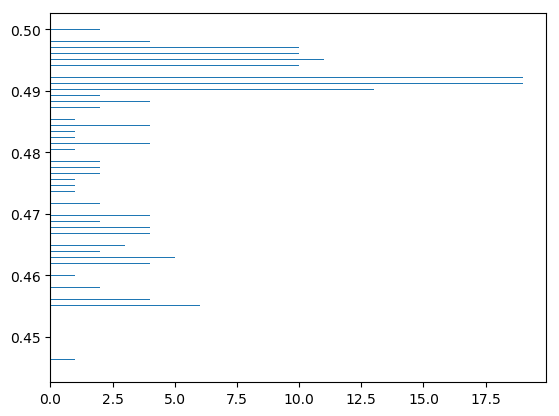

{'l_crossing': 0.0012689579256360078,
 'median_angles': 1.109636741751713,
 'overplotting': 0.33915576076320941,
 'p_norm': 0.9765625}

In [45]:
ci = 0
cj = 1

pd.tools.plotting.parallel_coordinates(dff, 'color', 
                                       colormap=ListedColormap(sns.color_palette("muted")[:3]),
                                       cols=[ci, cj])
plt.show()

pair_metrics(data_filtered, ci, cj)



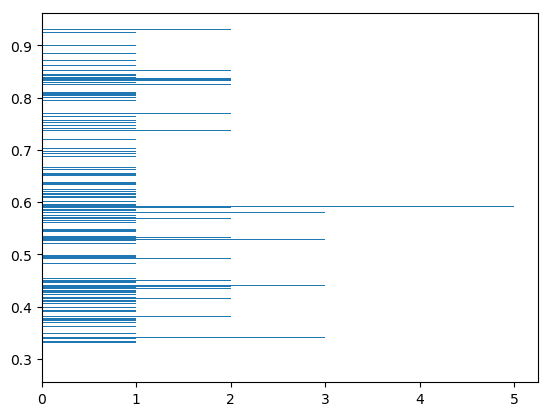

{'l_crossing': 0.061223397749510765,
 'median_angles': 34.621558297718693,
 'overplotting': 0.38823997064579258,
 'p_norm': 0.64404296875}

In [46]:
ci = 2
cj = 3

pd.tools.plotting.parallel_coordinates(dff, 'color', 
                                       colormap=ListedColormap(sns.color_palette("muted")[:3]),
                                       cols=[ci, cj])
plt.show()

pair_metrics(data_filtered, ci, cj)


In [29]:
m_orig = m_[:]
m_f_orig_low = m_f_low[:]

In [30]:
# selector = lambda d, k: d.get('l_crossing')

def extent(mat, k):
    ncols = len(mat)
    max_ = -np.inf
    min_ = np.inf
    for i in range(ncols):
        for j in range(ncols):
            if i!= j:
                t_ = mat[i][j][k]
                if t_ < min_: min_ = t_
                if t_ > max_: max_ = t_
    return min_, max_

def scale(mat, k, mm_sc):
    ncols = len(mat)
    min_sc = 0
    max_sc = 1
    min_, max_ = extent(mat, k)
    
    for i in range(ncols):
        for j in range(ncols):
            if i!= j:
                t_ = mat[i][j][k]
                t_ = (t_ - min_) / (max_ - min_)
                mat[i][j][k] = t_ * (max_sc - min_sc) + min_sc
#             else: mm_sc[i][j] = None
#     return mm_sc

                

In [31]:
ncols = len(m_)

m_sc = [None]*ncols
for i in range(ncols):
    m_sc[i] = [{}]*ncols
    
m_sc_f_low = [None]*ncols
for i in range(ncols):
    m_sc_f_low[i] = [{}]*ncols
        
for k in m_[0][1].keys():
    scale(m_, k, m_sc)
    scale(m_f_low, k, m_sc_f_low)
            

In [32]:
df_metrics = pd.DataFrame()
dff_metrics = pd.DataFrame()
dff_metrics_low = pd.DataFrame()
cp = sns.color_palette()

sel_metrics = {
    'l_crossing': (lambda d: d.get('l_crossing')),
    'overplotting': (lambda d: d.get('overplotting')),
    'median_angles': (lambda d: d.get('median_angles')),
#     'mutual': (lambda d: d.get('mutual')),
#     'entropy': (lambda d: 1-d.get('entropy')),
    'p_norm': (lambda d: 1-d.get('p_norm'))
}

metrics_names = ['l_crossing', 'overplotting', 'median_angles', 'p_norm']

for m_n in metrics_names:
#     print(m_n, path_m[m_n])
    all_m = []
    all_m_f = []
    all_m_f_low = []
    for i in range(ncols):
        for j in range(ncols):
            if i!=j:
                all_m.append(m_orig[i][j][m_n])
                all_m_f_low.append(m_f_orig_low[i][j][m_n])
                all_m_f.append(m_f_orig[i][j][m_n])
    df_metrics[m_n] = all_m
    dff_metrics[m_n] = all_m_f
    dff_metrics_low[m_n] = all_m_f_low

plt.figure(figsize=(10,5))
sns.swarmplot(data=df_metrics,
              size=5, color=cp[0], linewidth=0, alpha=.8)
sns.swarmplot(data=dff_metrics,
              size=5, color=cp[1], linewidth=0, alpha = .8)
sns.swarmplot(data=dff_metrics_low,
              size=5, color=cp[3], linewidth=0, alpha = .8)
plt.show()

NameError: name 'm_f_orig' is not defined

In [19]:
extent(m_, 'l_crossing')

(0.0, 1.0)

In [33]:
import tsp 

def get_axis_order(mat, sel_metric):
    ncols = len(mat)
    w = np.zeros((ncols, ncols))
    for i in range(ncols):
        for j in range(ncols):
            if i != j:
                w[i][j] = sel_metric(mat[i][j])
            else: 
                w[i][i] = np.inf
    cost, path = tsp.hcycle(w)
    n_order = [pi[0]-1 for pi in path[1:]]
    path_m = [sel_metric(mat[pi[0]-1][pi[1]-1]) for pi in path[1:-1]]
    return n_order, path_m, w




original
--------------------------------
[0.7744216587534094, 0.651985048994848, 0.33346802707344175, 0.0]
0.439968683705

l_crossing


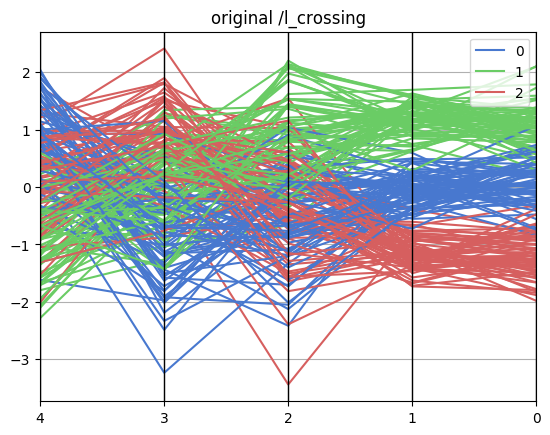

['4', '3', '2', '1', '0']


filtrado low
--------------------------------
[0.7174543022737404, 0.0, 0.2677775300936246, 0.4370820329915292]
0.35557846634

l_crossing


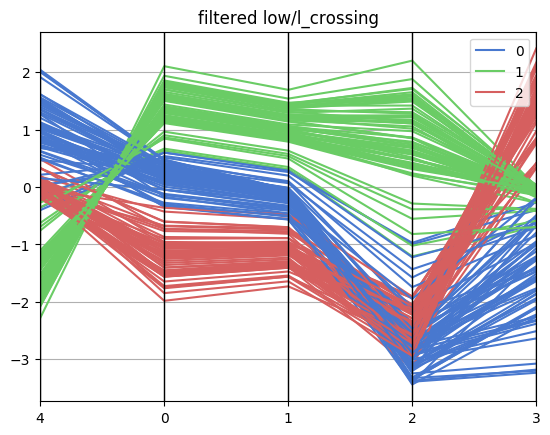

['4', '0', '1', '2', '3']


original
--------------------------------
[0.71095849507315623, 0.51425798745894313, 0.0, 0.13197969543147214]
0.339299044491

overplotting


['3', '4', '0', '1', '2']


filtrado low
--------------------------------
[0.60566606389391187, 0.0, 0.2328310227044402, 0.2580269238497086]
0.274131002612

overplotting


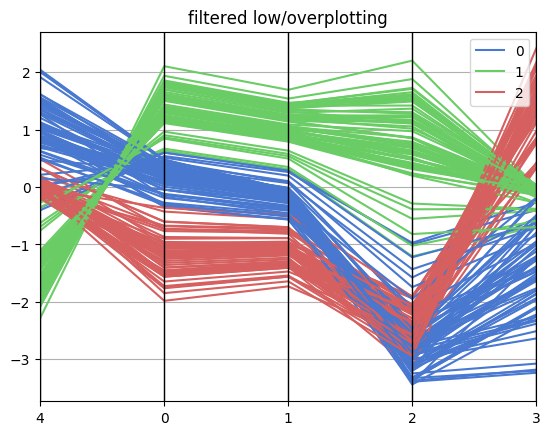

['4', '0', '1', '2', '3']


original
--------------------------------
[0.42715484363081613, 0.28756674294431728, 0.2387490465293669, 0.0]
0.238367658276

p_norm


['4', '3', '2', '0', '1']


filtrado low
--------------------------------
[0.65474339035769824, 0.70606531881804035, 0.22965266977708654, 0.0]
0.397615344738

p_norm


['4', '3', '2', '1', '0']


original
--------------------------------
[0.0, 0.32557155871778864, 0.35986535677706294, 0.54835993531988214]
0.308449212704

median_angles


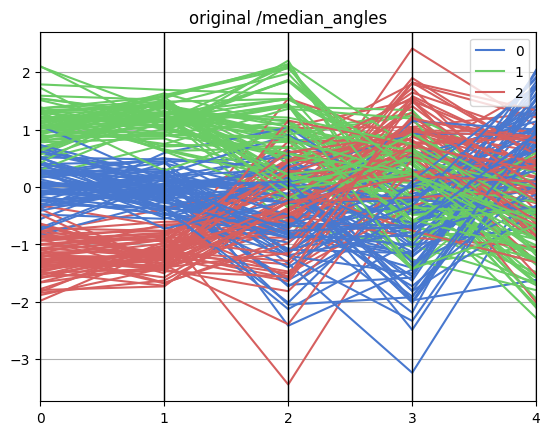

['0', '1', '2', '3', '4']


filtrado low
--------------------------------
[0.0, 0.34809359464503958, 0.58652986435231558, 0.74035199065595292]
0.418743862413

median_angles


['0', '1', '2', '4', '3']


In [36]:
sel_metric = lambda d: 1-d.get('entropy') #+ .5*(1-d.get('p_norm'))# p_norm invert

sel_metrics = {
    'l_crossing': (lambda d: d.get('l_crossing')),
    'overplotting': (lambda d: d.get('overplotting')),
    'median_angles': (lambda d: d.get('median_angles')),
#     'mutual': (lambda d: d.get('mutual')),
#     'entropy': (lambda d: 1-d.get('entropy')),
    'p_norm': (lambda d: 1-d.get('p_norm'))
}

metrics_names = sel_metrics.keys()
n_order = {}
path_m = {}

n_order_f = {}
path_m_f = {}

n_order_f_low = {}
path_m_f_low = {}

for m_n in metrics_names:
    print('\n\noriginal\n--------------------------------')
    n_order[m_n], path_m[m_n], w = get_axis_order(m_, sel_metrics[m_n])
    print(path_m[m_n])
    print(np.mean(path_m[m_n]))
    
#     plot_pc(df,Y)
#     print(col_names)
    
    print('\n' + m_n)
    plt.title('original /' + m_n)
    plot_pc(df,Y, n_order[m_n])
    print([col_names[i] for i in n_order[m_n]])

#     print('\n\nfiltrado enh\n--------------------------------')
#     n_order_f[m_n], path_m_f[m_n], w = get_axis_order(m_f, sel_metrics[m_n])
#     print(path_m_f[m_n])
#     print(np.mean(path_m_f[m_n]))

# #     plot_pc(dff,Y)
# #     print(col_names)
    
#     plt.title('filtered enh /' + m_n)
#     print('\n' + m_n)
#     plot_pc(dff,Y, n_order_f[m_n])
#     print([col_names[i] for i in n_order_f[m_n]])
    
    print('\n\nfiltrado low\n--------------------------------')
    n_order_f_low[m_n], path_m_f_low[m_n], w = get_axis_order(m_f_low, sel_metrics[m_n])
    print(path_m_f_low[m_n])
    print(np.mean(path_m_f_low[m_n]))

#     plot_pc(dff,Y)
#     print(col_names)
    
    plt.title('filtered low/' + m_n)
    print('\n' + m_n)
    plot_pc(dff,Y, n_order_f_low[m_n])
    print([col_names[i] for i in n_order_f_low[m_n]])


In [75]:
import matplotlib.patches as mpatches

sns.set_style("whitegrid", {'legend.frameon':True})
metrics_names = ['l_crossing', 'overplotting', 'median_angles', 'p_norm']

df_metrics = pd.DataFrame()
dff_metrics = pd.DataFrame()
dff_metrics_low = pd.DataFrame()
flatui = ["#3498db", "#e74c3c", "#2ecc71"]
cp = sns.color_palette(flatui)
for m_n in metrics_names:
#     print(m_n, path_m[m_n])
    df_metrics[m_n] = path_m[m_n]
    dff_metrics[m_n] = path_m_f[m_n]
    dff_metrics_low[m_n] = path_m_f_low[m_n]
    
df_metrics['p_norm'] = 1-df_metrics['p_norm']
dff_metrics['p_norm'] = 1-dff_metrics['p_norm']
dff_metrics_low['p_norm'] = 1-dff_metrics_low['p_norm']

plt.figure(figsize=(6,5))
sns.swarmplot(data=df_metrics,
              size=5, color=cp[0], linewidth=1, alpha=.8)#, label='raw data')
sns.swarmplot(data=dff_metrics,
              size=5, color=cp[1], linewidth=1, alpha=.8)#, label='low-pass')
sns.swarmplot(data=dff_metrics_low,
              size=5, color=cp[2], linewidth=1, alpha=.8)#, label='enhancement')

raw_patch = mpatches.Patch(color=cp[0], linewidth=1, label='raw')
low_patch = mpatches.Patch(color=cp[1], linewidth=1, label='low-pass')
enh_patch = mpatches.Patch(color=cp[2], linewidth=1, label='enh')
plt.legend(handles=[raw_patch,low_patch,enh_patch], loc=4)
plt.savefig('pc_metrics.pdf')
plt.show()

In [ ]:
data = X

size = 512
scaler = MinMaxScaler((0, size-1))
sc_data = np.floor(scaler.fit_transform(data))

n, ncols = data.shape
imgs = [None]*(ncols-1)
bins = [None]*(ncols)
R = [None]*(ncols-1)
L = [None]*(ncols-1)
D = [None]*(ncols-1)
H = [None]*(ncols-1)

for j in range(ncols-1):
    img = np.zeros((size, size), dtype=np.float64)
    img_ = np.zeros((size, size), dtype=np.float64)
    R[j] =np.zeros(n) 
    L[j] =np.zeros(n) 
    D[j] =np.zeros(n) 
    for i in range(n):
        y = sc_data[i, j:j+2]
        rr, cc = line(int(y[0]), 0, int(y[1]), size-1)
        img_[rr, cc] += 1
        R[j][i] = y[0]
        L[j][i] = y[1]
        D[j][i] = y[1] - y[0]
        rr, cc, v = line_aa(int(y[0]), 0, int(y[1]), size-1)
        img[rr, cc] += v
    bins[j] = img_[:,0]
    imgs[j] = img

bins[ncols-1] = img_[:,-1]
    
for c in range(ncols-1):
    H[c] = np.zeros((size, size), dtype=np.float64)
#     for i in range(size):
#         for j in range(size):
#             H[c][i,j] += (bins[c][i]>0 and bins[c+1][j]>0)

#     plt.imshow(H[c])
#     plt.show()
    H[c] = bins[c][np.newaxis].T * bins[c+1][np.newaxis]
#     plt.imshow(bins[c][np.newaxis].T*bins[c+1][np.newaxis])
#     plt.show()


a_l_crossing = [None]*(ncols-1)
a_median_angles = [None]*(ncols-1)
a_q50 = [None]*(ncols-1)
a_p_norm = [None]*(ncols-1)
n = R[0].shape[0]
for c in range(ncols-1):
    l_crossing = 0
    angles = []
    for i in range(n):
        for j in range(n):
            if (R[c][i] < R[c][j] and L[c][i] > L[c][j]) or (R[c][i] > R[c][j] and L[c][j] < L[c][j]):
                l_crossing += 1
                a = ang([[0, R[c][i]], [size, L[c][i]]], [[0, R[c][j]], [size, L[c][j]]])
                angles.append(a)

    mutual = 0
    convergence = 0
    divergence = 0
    for ri in range(size):
        for rj in range(size):
            pij = H[c][ri, rj]/size
            pi = bins[c][ri]/size
            pj = bins[c][rj]/size    
            if  pij > 0 and pi >0  and pj > 0:
                m = pij * np.log(pij/(pi*pj))
                mutual += m

    l_c_normalized = 2*l_crossing/(size*(size-1))
    median_angles = np.nanmedian(angles)
    par_nor = D[c]/size
    q75 = np.nanpercentile(par_nor, 75)
    q25 = np.nanpercentile(par_nor, 25)
    q50 = np.nanpercentile(D[c], 50)
    p_norm = 1-abs(q75-q25)

    a_l_crossing[c] = l_c_normalized
    a_median_angles[c] = (median_angles)
    a_q50[c] = q50
    a_p_norm[c]  =p_norm
    
    nbins = 256
    h_bins, _ = np.histogram(imgs[c], nbins)
    p_bins = h_bins/(size*size)
    p_bins[p_bins==0] = 0.5/(size*size)
    entropy_bins = np.sum(p_bins*np.log(1/p_bins))
    
    plt.imshow(imgs[c], cmap='gray_r')
    plt.show()
    
    
    print('l_crossing', l_c_normalized)
    print('median_angles', median_angles)
    print('p_norm', p_norm)
    print('mutual', mutual)
    print('entropy', entropy_bins)


# metrics_ = {
#     'l_crossing': np.mean(a_l_crossing),
#     'median_angles': np.mean(a_l_crossing),
#     'q50': np.mean(a_q50),
#     'p_norm': np.mean(a_p_norm)
# }


In [ ]:
data = datasets.load_wine()
Y = data.target
X = data.data
names = data.feature_names

df = pd.DataFrame(pr['data_filtered'].T )
if n_unique < 10:
    kwargs = {'vars': dff.columns[idx], 'hue': 'hue', 'palette': sns.color_palette("muted")}
    dff['color'] = Y

if n_unique < 10:
    pd.tools.plotting.parallel_coordinates(dff, 'color', colormap=ListedColormap(sns.color_palette("muted")[:n_unique]))
else:
    gsp_util.parallel_coordinates(dff, color='steelblue')
plt.show()


In [ ]:


if n_unique < 10:
    kwargs = {'vars': dff.columns, 'hue': 'color', 'palette': sns.color_palette("muted")}
    dff['color'] = Y

if n_unique < 10:
    pd.tools.plotting.parallel_coordinates(dff, 'color', colormap=ListedColormap(sns.color_palette("muted")[:n_unique]))
else:
    gsp_util.parallel_coordinates(dff, color='steelblue')
plt.show()



In [ ]:
size = 512
scaler = MinMaxScaler((0, size-1))

data = pr['data_filtered'].T
sc_data = np.round(scaler.fit_transform(data))
# mins = np.min(data, axis=0)
# maxs = np.max(data, axis=0)
# th = np.linspace(-90, 90, 50)

n, ncols = data.shape
imgs = [None]*(ncols-1)
bins = [None]*(ncols)
# H = [None]*(ncols-1)
R = [None]*(ncols-1)
L = [None]*(ncols-1)

for j in range(ncols-1):
    img = np.zeros((size, size), dtype=np.float64)
    R[j] =np.zeros(n) 
    L[j] =np.zeros(n) 
    for i in range(n):
        y = sc_data[i, j:j+2]
        rr, cc = line(int(y[0]), 0, int(y[1]), size-1)
        
        R[j][i] = y[0]
        L[j][i] = y[1]
        rr, cc, v = line_aa(int(y[0]), 0, int(y[1]), size-1)
        img[rr, cc] = 255
    bins[j] = img[:,0]
    imgs[j] = img
      
    plt.imshow(img, cmap='gray_r')
    plt.show()
    
    h, angles, d = hough_line(img)
    h_max = np.max(h)
    h_min = np.min(h)

    m = np.median(h[h>0])
    
    g = np.zeros(h.shape)
    g[h<=m] = h[h<=m]
    g[h>m] = m
    
    print('max', h_max)
    print('sum', np.sum(h)/2)
    print('sum g', np.sum(g))
    print('median', m)
    
    s = 1 - np.sum(h>m)/h.size
    print('s', s*100)

    
#     plt.imshow(h, cmap='gray', aspect=1/5, 
#            extent=(np.rad2deg(angles[-1]), np.rad2deg(angles[0]), d[-1], d[0]), 
#            vmin=0, vmax=h_max)
#     plt.show()
    
#     plt.imshow(g, cmap='gray', aspect=1/5, 
#                extent=(np.rad2deg(angles[-1]), np.rad2deg(angles[0]), d[-1], d[0]),
#               vmin=0, vmax=h_max)
#     plt.show()


bins[ncols-2] = imgs[ncols-2][:,-1]

In [ ]:
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]
def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = np.arccos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = np.degrees(angle)%360

    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else: 

        return ang_deg

In [ ]:
from skimage.draw import line_aa, line
from skimage.transform import hough_line
from sklearn.preprocessing import MinMaxScaler

size = 512
scaler = MinMaxScaler((0, size-1))

data = X
sc_data = np.round(scaler.fit_transform(data))
# mins = np.min(data, axis=0)
# maxs = np.max(data, axis=0)
# th = np.linspace(-90, 90, 50)

n, ncols = data.shape
imgs = [None]*(ncols-1)
bins = [None]*(ncols)
# H = [None]*(ncols-1)
R = [None]*(ncols-1)
L = [None]*(ncols-1)

for j in range(ncols-1):
    img = np.zeros((size, size), dtype=np.float64)
    R[j] =np.zeros(n) 
    L[j] =np.zeros(n) 
    for i in range(n):
        y = sc_data[i, j:j+2]
        rr, cc = line(int(y[0]), 0, int(y[1]), size-1)
        R[j][i] = y[0]
        L[j][i] = y[1]
        rr, cc, v = line_aa(int(y[0]), 0, int(y[1]), size-1)
        img[rr, cc] += v
    bins[j] = img[:,0]
    imgs[j] = img
bins[ncols-2] = imgs[ncols-2][:,-1]

# for c in range(ncols-1):
#     H[c] = np.zeros((size, size), dtype=np.float64)
#     for i in range(size):
#         for j in range(size):
#             H[c][i,j] += bins[c][i]>0 and bins[c][j]>0

    
#     plt.stem(img[:,0], markerfmt='')
#     plt.show()

#     plt.stem(img[:,-1], markerfmt='')
#     plt.show()
    
#     plt.imshow(img, cmap='gray_r')
#     plt.axis('equal')
#     plt.axis('off')
#     plt.show()

# for j in range(ncols-1):
#     plt.stem(img[:,0], markerfmt='')
#     plt.show()

#     plt.stem(img[:,-1], markerfmt='')
#     plt.show()

    
#     h, angles, d = hough_line(img)
#     plt.imshow(h,cmap='gray', aspect=1/5, extent=(np.rad2deg(angles[-1]), np.rad2deg(angles[0]), d[-1], d[0]))
#     plt.show()
    
#     m = np.median(h[h>0])
#     print(m)
#     g = np.zeros(h.shape) 
#     g[h>0] = m
#     g[h<m] = h[h<m]
# #     print(h.shape)
#     plt.imshow(g, cmap='gray', aspect=1/5, extent=(np.rad2deg(angles[-1]), np.rad2deg(angles[0]), d[-1], d[0]))
#     plt.show()

# def lines_crossing(R, L):
n = R[0].shape[0]
for c in range(ncols-1):
    l_crossing = 0
    angles = []
    par = np.zeros(n)
    for i in range(n):
        par[i] = R[c][i] - L[c][i]
        for j in range(n):
            if (R[c][i] < L[c][i] and R[c][j] < L[c][j]) or (R[c][i] > L[c][i] and R[c][j] > L[c][j]):
                l_crossing += 1
                a = ang([[0, R[c][i]], [size, L[c][i]]], [[0, R[c][j]], [size, L[c][j]]])
                angles.append(a)
    
    mutual = 0
    convergence = 0
    divergence = 0
    for ri in range(size):
        for rj in range(size):
            pij = H[c][ri, rj]/size
            pi = bins[c][ri]/size
            pj = bins[c][rj]/size    
            if  pij > 0 and pi >0  and pj > 0:
                m = pij * np.log(pij/(pi*pj))
                mutual += m
#             if H[c][rj, ri] > 0:
#                 convergence += 1
#             if H[c][ri, rj] > 0:
#                 divergence += 1
    
    l_c_normalized = 2*l_crossing/(size*(size-1))
    median_angles = np.nanmedian(angles)
    q75 = np.nanpercentile(par/size, 75)
    q25 = np.nanpercentile(par/size, 25)
    q50 = np.nanpercentile(par, 50)
    p_norm = 1-abs(q75-q25)
#     convergence_norm = convergence/np.max(H)
#     divergence_norm = divergence/np.max(H)
    
#     npix = size*size
#     entropy = np.sum(imgs[c]/npix * np.log(npix/imgs[c])) 
    
    plt.imshow(imgs[c], cmap='gray_r')
    plt.axis('equal')
    plt.axis('off')
    plt.show()
    print(l_c_normalized)
    print(median_angles)
#     print(par)
    print(q50)
    print(p_norm)
    print(mutual)
#     print(convergence_norm)
#     print(divergence_norm)
#     print(entropy)


In [ ]:
from skimage.draw import line_aa, line
from skimage.transform import hough_line
from sklearn.preprocessing import MinMaxScaler

def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]
def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = np.arccos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = np.degrees(angle)%360

    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else: 

        return ang_deg
    
def pc_metrics(data):
    size = 512
    scaler = MinMaxScaler((0, size-1))
    sc_data = np.round(scaler.fit_transform(data))

    n, ncols = data.shape
    imgs = [None]*(ncols-1)
    bins = [None]*(ncols)
    R = [None]*(ncols-1)
    L = [None]*(ncols-1)

    for j in range(ncols-1):
        img = np.zeros((size, size), dtype=np.float64)
        R[j] =np.zeros(n) 
        L[j] =np.zeros(n) 
        for i in range(n):
            y = sc_data[i, j:j+2]
            rr, cc = line(int(y[0]), 0, int(y[1]), size-1)
            R[j][i] = y[0]
            L[j][i] = y[1]
            rr, cc, v = line_aa(int(y[0]), 0, int(y[1]), size-1)
            img[rr, cc] += v
        bins[j] = img[:,0]
        imgs[j] = img
    bins[ncols-2] = imgs[ncols-2][:,-1]

    a_l_crossing = [None]*(ncols-1)
    a_median_angles = [None]*(ncols-1)
    a_q50 = [None]*(ncols-1)
    a_p_norm = [None]*(ncols-1)
    n = R[0].shape[0]
    for c in range(ncols-1):
        l_crossing = 0
        angles = []
        par = np.zeros(n)
        for i in range(n):
            par[i] = R[c][i] - L[c][i]
            for j in range(n):
                if (R[c][i] < L[c][i] and R[c][j] < L[c][j]) or (R[c][i] > L[c][i] and R[c][j] > L[c][j]):
                    l_crossing += 1
                    a = ang([[0, R[c][i]], [size, L[c][i]]], [[0, R[c][j]], [size, L[c][j]]])
                    angles.append(a)


        l_c_normalized = 2*l_crossing/(size*(size-1))
        median_angles = np.nanmedian(angles)
        q75 = np.nanpercentile(par/size, 75)
        q25 = np.nanpercentile(par/size, 25)
        q50 = np.nanpercentile(par, 50)
        p_norm = 1-abs(q75-q25)
        
        a_l_crossing[c] = l_c_normalized
        a_median_angles[c] = (median_angles)
        a_q50[c] = q50
        a_p_norm[c]  =p_norm
        
    metrics_ = {
        'l_crossing': np.mean(a_l_crossing),
        'median_angles': np.mean(a_l_crossing),
        'q50': np.mean(a_q50),
        'p_norm': np.mean(a_p_norm)
    }
    return metrics_

In [ ]:
metr = pc_metrics(X)

In [ ]:
print(metr)

In [ ]:
from skimage.draw import line_aa
from sklearn.preprocessing import MinMaxScaler

ac_size = 50
acc = np.zeros((ac_size, ac_size))

img = imgs[0]
nr, nc = img.shape

D = np.sqrt((nr - 1)**2 + (nc - 1)**2)
theta = np.linspace(-90, 90, ac_size)
rho = np.linspace(-D, D, ac_size)

print(rho.shape)

print(theta.shape)

for i in range(nr):
    for j in range(nc):
        if img[i, j] < 250:
            for ti in range(len(theta)):
                rhoVal = j*np.cos(theta[ti]*np.pi/180.0) + i*np.sin(theta[ti]*np.pi/180)
                ri = np.nonzero(np.abs(rho-rhoVal) == np.min(np.abs(rho-rhoVal)))[0]
                acc[ri[0], ti] += 1
            
                


In [ ]:
# reload(gsp_util)

kwargs = {}
if n_unique < 10:
    kwargs = {'vars': range(n_features), 'hue': 'color', 'palette': sns.color_palette("muted")}
pg = sns.pairplot(df, diag_kind='hist', **kwargs)
plt.show()

fig=plt.figure(figsize=(14,6))
if n_unique < 10:
    pd.tools.plotting.parallel_coordinates(df, 'color', colormap=ListedColormap(sns.color_palette("muted")[:n_unique]))
else:
    gsp_util.parallel_coordinates(df, color='steelblue')
plt.show()

corr = np.corrcoef(X.T)
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap="RdBu_r", square=True) # compute and plot the pair-wise correlations
plt.show()

dist = ss.distance.pdist(X, metric='euclidean')
plt.hist(dist, 50, normed=1)
plt.show()

In [ ]:
# reload(gsp_util)

n_neighbors = 5

graph = gsp_util.get_graph(X, n_neighbors)



In [ ]:
if n_unique < 10:
    node_color = Y
else:
    node_color = 'steelblue'
    
pos = gsp_util.get_layout(mode='force', data=X, graph=graph['G']) #mode: pca, force
plt.title('force')
nx.draw(graph['G'], pos=pos, node_color=node_color, node_size=20, 
        edge_color='#dddddd', cmap=ListedColormap(sns.color_palette("muted")[:n_unique]))
plt.show()

pos_pca = gsp_util.get_layout(mode='pca', data=X, graph=graph['G']) #mode: pca, force
plt.title('pca')
nx.draw(graph['G'], pos=pos_pca, node_color=node_color, node_size=20, 
        edge_color='#dddddd', cmap=ListedColormap(sns.color_palette("muted")[:n_unique]))
plt.show()

pos_tsne = gsp_util.get_layout(mode='tsne', data=X, graph=graph['G']) #mode: pca, force
plt.title('tsne')
nx.draw(graph['G'], pos=pos_tsne, node_color=node_color, node_size=20, 
        edge_color='#dddddd', cmap=ListedColormap(sns.color_palette("muted")[:n_unique]))
plt.show()

In [ ]:
# reload(gsp_filter_design)
# reload(gsp_util)
# reload(gsp_filter)

# lmax=graph['lam'][-1]
# g = gsp_filter_design.high_pass_4(lmax, 5)
# filt_h = g(graph['lam'])
# graph['filt'] = filt_h
# gsp_util.plot_filter(graph)

# pr_h = gsp_filter.analyze(X, graph)#, plot2=True)
# dist = ss.distance.pdist(pr['data_filtered'].T, metric='euclidean')
# plt.hist(dist, 50, normed=1)
# plt.show()

a = .5
b = 1-a

lmax=graph['lam'][-1]
g_l = gsp_filter_design.low_pass_4(lmax, 50)
g_h = gsp_filter_design.high_pass_4(lmax, 2)

filt_h = g_h(graph['lam'])
graph['filt'] = filt_h
gsp_util.plot_filter(graph)
pr_h = gsp_filter.analyze(X, graph)

filt = a * g_l(graph['lam']) + b *g_h(graph['lam'])
graph['filt'] = filt
gsp_util.plot_filter(graph)

pr = gsp_filter.analyze(X, graph)

imp = gsp_util.compute_importance(X, graph=graph)
idx = np.argsort(imp)[::-1]

corr = np.corrcoef(pr['data_filtered'])
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, cmap="RdBu_r", vmin=-1, vmax=1, square=True) # compute and plot the pair-wise correlations
plt.show()

dist = ss.distance.pdist(pr['data_filtered'].T, metric='euclidean')
plt.hist(dist, 50, normed=1)
plt.show()


In [ ]:

dff = pd.DataFrame(pr['data_filtered'].T )
kwargs = {}
if n_unique < 10:
    kwargs = {'vars': dff.columns[idx], 'hue': 'color', 'palette': sns.color_palette("muted")}
    dff['color'] = Y
pg = sns.pairplot(dff, diag_kind='hist', **kwargs)
plt.show()

if n_unique < 10:
    pd.tools.plotting.parallel_coordinates(dff, 'color', cols=idx, colormap=ListedColormap(sns.color_palette("muted")[:n_unique]))
else:
    gsp_util.parallel_coordinates(dff, color='steelblue', cols=idx)
plt.show()

pos_pca_f = gsp_util.get_layout(mode='pca', data=pr['data_filtered'].T , graph=graph['G']) #mode: pca, force
plt.title('pca')
nx.draw(graph['G'], pos=pos_pca_f, node_color=node_color, node_size=20,
         edge_color='#dddddd', cmap=ListedColormap(sns.color_palette("muted")[:n_unique]))
plt.show()

pos_tsne_f = gsp_util.get_layout(mode='tsne', data=pr['data_filtered'].T, graph=graph['G']) #mode: pca, force
plt.title('tsne')
nx.draw(graph['G'], pos=pos_tsne_f, node_color=node_color, node_size=20, 
        edge_color='#dddddd', cmap=ListedColormap(sns.color_palette("muted")[:n_unique]))
plt.show()



In [ ]:
reload(gsp_util)
gsp_util.plot_features_and_fourier(pr, graph, X, pos_pca, order=idx, s=(pr_h['data_filtered']**2)*1000)

In [ ]:
reload(gsp_util)

gsp_util.plot_features_and_freq(graph, X, pos_pca, order=idx, 
                                s=np.abs(pr_h['data_filtered']).T,
                                c=Y, cmap=ListedColormap(sns.color_palette("muted")[:n_unique]))


In [ ]:
type(pr_h['data_filtered']) is not int

In [ ]:
X.shape

In [ ]:
pr_h['data_filtered'].shape

In [ ]:
np.array([graph['lam'], filt])